# Agentic AI Architecture

# 01 : Reflection

### Defination
Its defined as an architecture which involves an agent critiquing and revising its own output before returning a final answer. Instead of a single-pass generation, it engages in a multi-step internal thinking: re-producing, evaluating and improving. This mimics the human process of drafting reviewing and editing to catch errors and enhance answer quality

### High Level workflow
1. Generate: The agent produces an initial draft or sulution based on the user's prompt.
2. Critique: The agent then switches roles to become a self critic. It asks itself questions like: "_What could be wrong with this answer?_", or "_What is missing?_" etc
3. Refine: Using the insights from its self-critique, the agent generates a final, improved version of the output.

### When to Use / Applications
- code generation: Inifial codes might have bugs, be inefficient or lack comments. Reflection allows the agent to act as its own code reviewer, finding errors and improving style before presenting the final script
- complex summary: When summarizing a dense document, a first pass might miss some key details. A reflection step helps ensuring the summary is comprehensive and accurate.
- creative writing and content creation: The initial email or blg post or story can always be improved. Reflection allows the agent to refine its tone and clarity and impact.

### Weaknesses and strengths
**Strengths**
- Improved Quality: More accure, robust and well reasoned output
- Low Overhead: Conceptually simple pattern that can be implemented with a single LLM 

**Weakness**
- Self-Bias: The agent is still limited by its own knowledge and biases. If it doesn't know a better way to solve a problem, it can't critique its way to a better solution. It can fix flaws it recognizes but cant invert knowledge it lacks.
- Increased Latency and cost: This is a token heavy method, as it involves minimum 2 LLM calls (generation+critique/refinement), making it slower and more expensive than a single pass approach


# Working

### Step1: Importing and setting up

In [33]:
import os
import json
from typing import List, TypedDict, Optional, Union
from dotenv import load_dotenv

from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END

from rich.console import Console
from rich.markdown import Markdown
from rich.syntax import Syntax

load_dotenv()

True

### Phase 1 : Building the Core Components of Reflection
A reflection architecture is more than just a simple prompt. We will build it as a structured three-part system:
`Generator`, `critic` and a `refiner`. To ensure reliablilty, we will use our beloved Pydantic model to define the expected output schemas for each step

### Step 1.1 : Define the Scehmas with Pydantic
We will define pydantic models that acts as a contract for our LLM. This tells the LLM exactly what structure its output should have, which is critical for a multistep process where the output of one step becomes the imput of next step

In [34]:
class DraftCode(BaseModel):
    """Schema for the initial code fraft generated by the agnet"""
    code: str = Field(description="The python code generated to solve the user's request.")
    explanation: str = Field(description="A brief explanation of how the code works")

class Critique(BaseModel):
    """Schema for the self-critique of the generated code"""
    has_errors: Union[bool, str] = Field(description="Does the code have any potential buges or logical errors?")
    is_sufficient: Union[bool, str] =Field(description="Is the code written is an sufficient in its optimal way?")
    suggested_improvements: List[str] = Field(description="specific, actionable suggestions for improving the code. If any.")
    critique_summary: str = Field(description="A summary of the critique.")

class RefinedCode(BaseModel):
    """Schema for the final, refined code after incorporating the critique"""
    refined_code: str = Field(description="The final, improved Python code")
    refinement_summary: str = Field(description="A summary of the changes made based on the critique")


def _to_bool(value):
    if isinstance(value, bool):
        return value
    if isinstance(value, str):
        normalized = value.strip().lower()
        if normalized in ("true", "false"):
            return normalized == "true"
    raise ValueError(f"Unexpected boolean value: {value!r}")

print("Pydantic model ready sir!")

Pydantic model ready sir!


### Step 1.2: Initialize the LLM

In [35]:
llm = ChatGroq(model="llama-3.1-8b-instant")
console = Console()
print("Model ready sir!")

Model ready sir!


### Step 1.3: Creating the generator Node
This node only job is to take the user request and produce the first draft. We will bind our Draft code pydantic model to the LLM to ensure structured output

In [36]:
def generator_node(state):
    """Generates the initial draft of the code."""
    console.print("GENERATING INITIAL DRAFT")
    generator_llm = llm.with_structured_output(DraftCode)

    prompt = f"""You are an expert python programmer. Write a function to solve the following request.

    Request: {state['user_request']}
    """

    draft = generator_llm.invoke(prompt)
    return {"draft": draft.model_dump()}

### Step 1.4: Creating the Critic Node (Core of Reflection process)
The Critic node takes the initial draft, analyzes it for flaws, and produces a structured critique using the critique pydantic model

In [37]:
def critic_node(state):
    """Critiques the generated code for errors and inefficiencies."""
    console.print("CRITIQUING DRAFT")
    critic_llm = llm.with_structured_output(Critique)

    code_to_critique = state['draft']['code']

    prompt = f"""You are an expert code reviewer and senior Python developer. Your task is to perform a thorough critique check of the following code.
    Analyze the code for:
    1. Bugs and Errors
    2. Efficiency and Best Practices
    
    Provide a structured critique with specific, actionable suggestions.

    Code to Review:-
    ```
    {code_to_critique}
    ```
    """
    critique = critic_llm.invoke(prompt)
    
    critique_data = critique.model_dump()
    critique_data["has_errors"] = _to_bool(critique_data["has_errors"])
    critique_data["is_sufficient"] = _to_bool(critique_data["is_sufficient"])
    return {"critique": critique_data}


### Step 1.5 : Creating the Refiner Node
This final step in our logic recieves both the original draft and the structured critique and is tasked with writing final and improved code


In [38]:
def refiner_node(state):
    """Refines the code based on the critique."""
    console.print("--- 3. Refining Code ---")
    refiner_llm = llm.with_structured_output(RefinedCode)
    
    draft_code = state['draft']['code']
    critique_suggestions = json.dumps(state['critique'], indent=2)
    
    prompt = f"""You are an expert Python programmer tasked with refining a piece of code based on a critique.
    
    Your goal is to rewrite the original code, implementing all the suggested improvements from the critique.
    
    **Original Code:**
    ```python
    {draft_code}
    ```
    
    **Critique and Suggestions:**
    {critique_suggestions}
    
    Please provide the final, refined code and a summary of the changes you made.
    """
    
    refined_code = refiner_llm.invoke(prompt)
    return {"refined_code": refined_code.model_dump()} # Corrected: use .model_dump()

## Phase 2 : Orchestrating the Reflection workflow with LangGraph
### Step 2.1: Defining the Graph State
The 'state' is the memory of our graph. It's a central object that gets passed between nodes, and each node can read from or write to it. We will define a ReflectionState using TypeDict to hold all pirces of workflow

In [39]:
class ReflectionState(TypedDict):
    """Represents the sate of our reflection graph"""
    user_request: str
    draft: Optional[dict]
    critique: Optional[dict]
    refined_code: Optional[dict]

print("ReflectionState TypeDict defined!")

ReflectionState TypeDict defined!


### Step 2.2 : Building and Visualizing the Graph
The workflow is a simple linear sequence: **Generate → Critique → Refine**. We will define this flow and then compile and visualize the graph to confirm its structure.

In [40]:
graph_builder = StateGraph(ReflectionState)

graph_builder.add_node("generator", generator_node)
graph_builder.add_node("critique", critic_node)
graph_builder.add_node("refiner", refiner_node)

# Define the workflow edges
graph_builder.set_entry_point("generator")
graph_builder.add_edge("generator", "critique")
graph_builder.add_edge("critique", "refiner")
graph_builder.add_edge("refiner", END)

# Compile the graph
reflection_app = graph_builder.compile()

print("Reflection graph compiled successfully")

Reflection graph compiled successfully


In [41]:
# Visualize the graph
try:
    from IPython.display import Image, display
    png_image = reflection_app.get_graph().draw_png()
    display(Image(png_image))
except Exception as e:
    print(f"Graph visualization failed: {e}. Please ensure pygraphviz is installed.")

Graph visualization failed: Install pygraphviz to draw graphs: `pip install pygraphviz`.. Please ensure pygraphviz is installed.


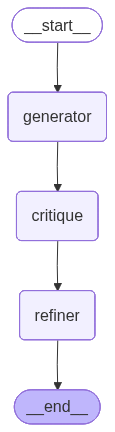

In [42]:
# Another PNG method that sometimes works better
try:
    from IPython.display import Image, display
    
    mermaid_png = reflection_app.get_graph().draw_mermaid_png()
    display(Image(mermaid_png))
except Exception as e:
    print(f"Mermaid PNG failed: {e}")

## Phase 3: End-to-End Execution and Evaluation

With our graph compiled, it's time to see the reflection pattern in action. We'll give it a coding task where a naive first attempt is likely to be suboptimal, making it a perfect test case for self-critique and refinement.

### Step 3.1: Running the Full Reflection Workflow
We will invoke our compiled LangGraph application with a request to write a function to find the nth Fibonacci number. We will stream the results and properly accumulate the full state so we can inspect all intermediate steps at the end.

In [43]:
user_request = "Write a Python function to find the nth Fibonacci number."
initial_input = {"user_request": user_request}

console.print(f"[bold cyan]🚀 Kicking off Reflection workflow for request:[/bold cyan] '{user_request}'\n")

final_state = None
for state_update in reflection_app.stream(initial_input, stream_mode="values"):
    final_state = state_update

console.print("\n[bold green]✅ Reflection workflow complete![/bold green]")

🚀 Kicking off Reflection workflow for request: 'Write a Python function to find the nth Fibonacci number.'

GENERATING INITIAL DRAFT

CRITIQUING DRAFT

--- 3. Refining Code ---

✅ Reflection workflow complete!

### Step 3.2: Analyzing the 'Before and After'
We will now inspect the outputs from each stage of the workflow, stored in our `final_state`. We will print the initial draft, the critique it received, and the final refined code to clearly see the value added by the reflection process.

In [44]:
# Check if final_state is available and has the expected keys
if final_state and 'draft' in final_state and 'critique' in final_state and 'refined_code' in final_state:
    console.print(Markdown("--- ### Initial Draft ---"))
    console.print(Markdown(f"**Explanation:** {final_state['draft']['explanation']}"))
    # Use rich's Syntax for proper code highlighting
    console.print(Syntax(final_state['draft']['code'], "python", theme="monokai", line_numbers=True))

    console.print(Markdown("\n--- ### Critique ---"))
    console.print(Markdown(f"**Summary:** {final_state['critique']['critique_summary']}"))
    console.print(Markdown(f"**Improvements Suggested:**"))
    for improvement in final_state['critique']['suggested_improvements']:
        console.print(Markdown(f"- {improvement}"))

    console.print(Markdown("\n--- ### Final Refined Code ---"))
    console.print(Markdown(f"**Refinement Summary:** {final_state['refined_code']['refinement_summary']}"))
    console.print(Syntax(final_state['refined_code']['refined_code'], "python", theme="monokai", line_numbers=True))
else:
    console.print("[bold red]Error: The `final_state` is not available or is incomplete. Please check the execution of the previous cells.[/bold red]")

--- ### Initial Draft ---

Explanation: This function uses a simple iterative approach to calculate the nth Fibonacci number. It initializes  
two variables a and b with the first two Fibonacci numbers (0 and 1), then iteratively calculates the next         
Fibonacci number by adding a and b, updating a and b for the next iteration.

  1 def fibonacci(n):\n    if n <= 0:\n        return "Input should be a positive integer."\n    elif n == 1:\n    

--- ### Critique ---

Summary: The provided Python code implements the Fibonacci sequence calculation. However, there are some areas that
require improvement for better efficiency and adherence to best practices.

Improvements Suggested:

 • Use memoization to avoid redundant calculations for larger inputs.

 • Consider using a more efficient algorithm like matrix exponentiation for large inputs.

 • Implement error handling for invalid input types.

 • Add type hints for function parameters and return types.

 • Use consistent naming conventions and follow PEP 8 guidelines.

--- ### Final Refined Code ---

Refinement Summary: Implemented memoization, added type hints, improved error handling, and followed PEP 8         
guidelines for naming conventions.

   1 def fibonacci(n: int) -> int:                                                                                 
   2     if not isinstance(n, int) or n <= 0:                                                                      
   3         raise ValueError('Input should be a positive integer.')                                               
   4     elif n == 1:                                                                                              
   5         return 0                                                                                              
   6     elif n == 2:                                                                                              
   7         return 1                                                                                              
   8     else:                                                                                                     
   9         memo = {1: 0, 2: 1}                                                                                   
  10         for i in range(3, n + 1):                                                                             
  11             memo[i] = memo[i - 1] + memo[i - 2]                                                               
  12         return memo[n]                                                                                        
  13                                                                                                               

### Step 3.3: Quantitative Evaluation (LLM-as-a-Judge)
 we will use another LLM as an impartial 'judge' to score the quality of the initial draft versus the final code. This provides a more objective measure of the improvement gained through reflection.

In [45]:
class CodeEvaluation(BaseModel):
    """Schema for evaluating a piece of code."""
    correctness_score: int = Field(description="Score from 1-10 on whether the code is logically correct.")
    efficiency_score: int = Field(description="Score from 1-10 on the code's algorithmic efficiency.")
    style_score: int = Field(description="Score from 1-10 on code style and readability (PEP 8). ")
    justification: str = Field(description="A brief justification for the scores.")

judge_llm = llm.with_structured_output(CodeEvaluation)

def evaluate_code(code_to_evaluate: str):
    prompt = f"""You are an expert judge of Python code. Evaluate the following function on a scale of 1-10 for correctness, efficiency, and style. Provide a brief justification.
    
    Code:
    ```python
    {code_to_evaluate}
    ```
    """
    return judge_llm.invoke(prompt)

if final_state and 'draft' in final_state and 'refined_code' in final_state:
    console.print("--- Evaluating Initial Draft ---")
    initial_draft_evaluation = evaluate_code(final_state['draft']['code'])
    console.print(initial_draft_evaluation.model_dump()) # Corrected: use .model_dump()

    console.print("\n--- Evaluating Refined Code ---")
    refined_code_evaluation = evaluate_code(final_state['refined_code']['refined_code'])
    console.print(refined_code_evaluation.model_dump()) # Corrected: use .model_dump()
else:
    console.print("[bold red]Error: Cannot perform evaluation because the `final_state` is incomplete.[/bold red]")

--- Evaluating Initial Draft ---

{
    'correctness_score': 8,
    'efficiency_score': 4,
    'style_score': 6,
    'justification': 'The code correctly calculates the nth Fibonacci number but uses a naive approach that has a 
time complexity of O(n), which is inefficient for large inputs. It also has some minor issues with style, such as 
inconsistent spacing and a return value for n=1 that is not necessary. However, the logic is mostly correct and 
easy to understand.'
}

--- Evaluating Refined Code ---

{
    'correctness_score': 9,
    'efficiency_score': 8,
    'style_score': 9,
    'justification': 'The code correctly implements the Fibonacci sequence using memoization. However, it could be 
improved slightly for efficiency by using a more memory-efficient data structure, such as a list or array. 
Style-wise, the code follows PEP 8 conventions and is well-structured.'
}